In [186]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

# use pillow for checking image sizes
import os
from PIL import Image

# Checking Image Sizes

In [160]:
# function to identify all unique image sizes for images in a directory
def print_img_sizes(path):
    # Get a list of all image file names in the directory
    image_files = [file for file in os.listdir(path) if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Create a set to store unique image sizes
    unique_sizes = set()

    # Iterate over each image file and store its size in the set
    for image_file in image_files:
        image_path = os.path.join(path, image_file)
        with Image.open(image_path) as image:
            width, height = image.size
            size = (width, height)
            unique_sizes.add(size)

    # Print the unique image sizes
    print("Unique Image Sizes:")
    for size in unique_sizes:
        print(f"{size[0]}x{size[1]}")

In [161]:
print_img_sizes('../data/test/FAKE/')

Unique Image Sizes:
32x32


Images are 32x32, and are in color.

# Build ImageDataGenerator Classes for Training

In [162]:
# build an instance of the ImageDataGenerator class
datagen = ImageDataGenerator(
    rescale=1.0/255,
)

In [163]:
# build the training set
train_generator = datagen.flow_from_directory(
    directory="../data/train",
    target_size=(32,32),
    batch_size=32,
    class_mode="categorical",
)

Found 100000 images belonging to 2 classes.


In [164]:
# build the training set, this generator has contains the attribute shuffle = False. This set is used to check for overfitting.
train_generator_static = datagen.flow_from_directory(
    directory="../data/train",
    target_size=(32,32),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 100000 images belonging to 2 classes.


In [165]:
print("Image shape of each observation: ",train_generator.image_shape)
print("Number of classes: ",train_generator.num_classes)

Image shape of each observation:  (32, 32, 3)
Number of classes:  2


# Build ImageDataGenerator Class for Testing

In [166]:
# Generate the test set
test_generator = datagen.flow_from_directory(
    directory="../data/test",
    target_size=(32,32),
    class_mode="categorical",
    shuffle=False # Make sure this is false so that predictions will align w correct image labels later on
)

Found 20000 images belonging to 2 classes.


# Build the Neural Network

In [167]:
# Define model as a function so that we can perform hyperparameter tuning
def create_model(filters=32,kernel_size=(3,3), pool_size=(2,2), hidden_units=128, dropout_rate=.5, learning_rate=0.001):

    # Create an instance of Sequential
    classifier = Sequential()

    # Add a Conv2D layer. Applies a set of filters to the input data, each filter learns to recognize different patterns or features
    classifier.add(Conv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        input_shape=train_generator.image_shape, 
                        activation='relu')
                        )

    # Add a MaxPooling2d layer. Performs downsampling on the data, reduces dimensions. Divides input data into non-overlapping regions (pooling windows).
    # Maximum value is output within each window.
    classifier.add(MaxPooling2D(pool_size))

    classifier.add(Conv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        input_shape=train_generator.image_shape, 
                        activation='relu')
                        )
    
    classifier.add(MaxPooling2D(pool_size))
    classifier.add(Dropout(dropout_rate))

    classifier.add(Conv2D(filters=filters, 
                        kernel_size=kernel_size, 
                        input_shape=train_generator.image_shape, 
                        activation='relu')
                        )
    
    classifier.add(MaxPooling2D(pool_size))
    
    classifier.add(Dropout(dropout_rate))

    # Add a Flatten layer. Reshape data into a 1d array. Transition the convolution and pooling layers to the fully connected layers.
    classifier.add(Flatten())

    # Add a Dense layer. A fully connected layer, allows for the learning of relationships. Activation function introduces non-linearity
    classifier.add(Dense(hidden_units,
                        activation='relu')
                        )

    # Add a Final Dense layer. This will output our probabilities.
    classifier.add(Dense(units=train_generator.num_classes,
                        activation='sigmoid')
                        )

    # Compile the model
    classifier.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return classifier

### Train and Evaluate the Model

In [168]:
 # Create and compile a model with the selected hyperparameters
model = create_model(filters=256,kernel_size=(3,3), pool_size=(2,2), hidden_units=16, dropout_rate=0.2, learning_rate=0.001)
print(model.summary())

# Train the model, passing in the test set for validation
model.fit(train_generator, epochs=5, batch_size=32,verbose=1, validation_data=test_generator)

# save the model to disk
model.save('mod_1.h5')
print('Model saved to disk')

Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_462 (Conv2D)         (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_462 (MaxPooli  (None, 15, 15, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_463 (Conv2D)         (None, 13, 13, 256)       590080    
                                                                 
 max_pooling2d_463 (MaxPooli  (None, 6, 6, 256)        0         
 ng2D)                                                           
                                                                 
 dropout_305 (Dropout)       (None, 6, 6, 256)         0         
                                                                 
 conv2d_464 (Conv2D)         (None, 4, 4, 256)      

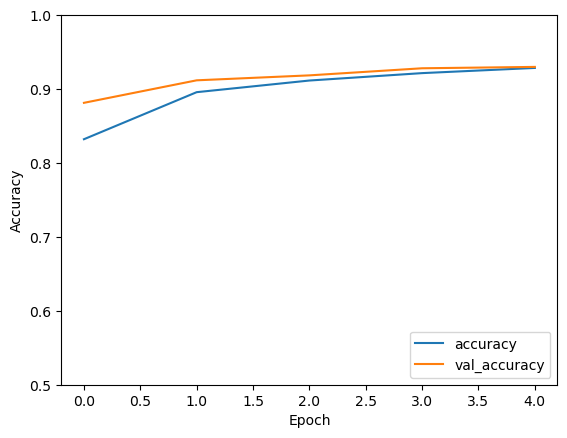

In [169]:
# Model performance history by epoch
def performance_history(model):
    plt.plot(model.history.history['accuracy'], label='accuracy')
    plt.plot(model.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    plt.show()

performance_history(model)

In [170]:
# function for evaluating model performance and generating predictions
def evaluate_model(path_to_mod, generator):
    # Load the trained model
    model = keras.models.load_model(path_to_mod)

    # Make predictions on the test set
    predictions = model.predict(generator)

    # Convert the predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class labels
    true_classes = generator.classes

    accuracy = accuracy_score(predicted_classes, true_classes)
    print('Prediction Accuracy: ', accuracy)

    return predicted_classes,true_classes

In [187]:
# Predicting on train data, this is our check for overfitting
preds, actual = evaluate_model('mod_1.h5', train_generator_static)
print(classification_report(preds, actual))
print("Class Labels: ", train_generator_static.class_indices)

3125/3125 [==============================] - 45s 14ms/step
Prediction Accuracy:  0.9433
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     49508
           1       0.95      0.94      0.94     50492

    accuracy                           0.94    100000
   macro avg       0.94      0.94      0.94    100000
weighted avg       0.94      0.94      0.94    100000

Class Labels:  {'FAKE': 0, 'REAL': 1}


In [190]:
# Predicting on test data
preds, actual = evaluate_model('mod_1.h5', test_generator)
print(classification_report(preds, actual))
print("Class Labels: ", test_generator.class_indices)

625/625 [==============================] - 11s 18ms/step
Prediction Accuracy:  0.92995
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      9855
           1       0.94      0.92      0.93     10145

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Class Labels:  {'FAKE': 0, 'REAL': 1}


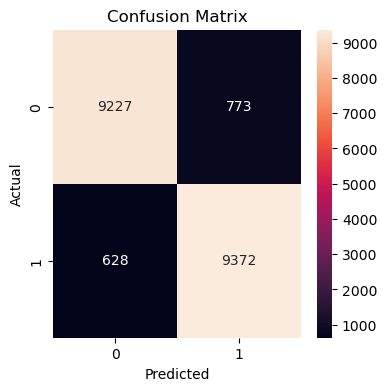

In [193]:
cm = confusion_matrix(actual,preds)
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(4,4), edgecolor='brown')
sns.heatmap(cm , annot= True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Generate ROC curve for test predictions

625/625 [==============================] - 10s 16ms/step


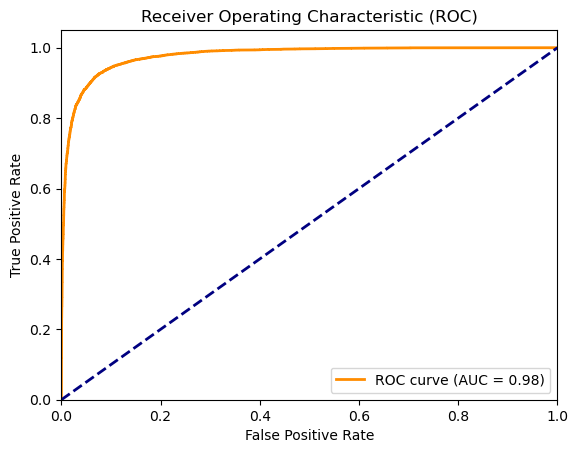

In [183]:
from sklearn.metrics import roc_curve, auc

# Load the trained model
model = keras.models.load_model('mod_1.h5')

# Make predictions on the test set
predictions = model.predict(test_generator)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions[:,1])

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Random Grid Search

Performing a random grid search on a number of hyper parameters will assist us with fine tuning our model for the best performance.

In [173]:
# Define a hyper parameter grid
param_grid = {
    'filters': [64, 128, 256, 512],
    'kernel_size': [(2, 2), (3, 3), (4,4)],
    'pool_size': [(2, 2)],
    'hidden_units': [8, 10, 16, 32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [.0005,.001, 0.002]
}

# Perform random grid search
num_iterations = 12
best_accuracy = 0.0 # placeholder to track best accuracy
best_params = None # placeholder to track best parameters

# Create a dataframe to track model performance using various hyper parameters
col_names = list(param_grid.keys()) # names of hyper parameters
params_df = pd.DataFrame(columns=col_names)
mod_df = pd.DataFrame(columns=['mod_name','accuracy'])
params_df = pd.concat([params_df, mod_df], axis=1) # combine to create df for performance tracking

for i in range(num_iterations):
    # Randomly select hyperparameters from the grid
    params = {param: random.choice(values) for param, values in param_grid.items()}

    print(params)

    # Create and compile the model with the selected hyperparameters
    model = create_model(**params)

    # Train the model
    model.fit(train_generator, epochs=5, batch_size=32,verbose=0)

    # save the model to disk
    mod_name = 'mod_rgs_'+str(i)+'.h5'
    model.save(mod_name)
    print('Model saved to disk')

    preds, actual = evaluate_model(mod_name, test_generator)

    accuracy = accuracy_score(preds,actual)

    # add a row to our tracker dataframe
    converted_list = [str(item) if isinstance(item, set) else item for item in list(params.values())] # convert items in a list that are a set to string
    converted_list.extend([mod_name, accuracy])
    params_df = pd.concat([params_df, pd.DataFrame([converted_list], columns=params_df.columns)], ignore_index=True) # add new row to tracker df

    # Check if the current model outperforms the previous best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

        model.save('best_model.h5')

{'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'hidden_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.002}
Model saved to disk
625/625 [==============================] - 5s 8ms/step
Prediction Accuracy:  0.8867
{'filters': 256, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'hidden_units': 8, 'dropout_rate': 0.4, 'learning_rate': 0.001}
Model saved to disk
625/625 [==============================] - 5s 8ms/step
Prediction Accuracy:  0.9288
{'filters': 64, 'kernel_size': (4, 4), 'pool_size': (2, 2), 'hidden_units': 8, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
Model saved to disk
625/625 [==============================] - 5s 8ms/step
Prediction Accuracy:  0.92045
{'filters': 64, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'hidden_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.002}
Model saved to disk
625/625 [==============================] - 5s 8ms/step
Prediction Accuracy:  0.92225
{'filters': 256, 'kernel_size': (4, 4), 'pool_size': (2, 2), 'hidden_units': 16, 

In [174]:
params_df

,filters,kernel_size,pool_size,hidden_units,dropout_rate,learning_rate,mod_name,accuracy
0,64,"(3, 3)","(2, 2)",128,0.5,0.0020,mod_rgs_0.h5,0.88670
1,256,"(2, 2)","(2, 2)",8,0.4,0.0010,mod_rgs_1.h5,0.92880
2,64,"(4, 4)","(2, 2)",8,0.4,0.0005,mod_rgs_2.h5,0.92045
3,64,"(2, 2)","(2, 2)",64,0.3,0.0020,mod_rgs_3.h5,0.92225
4,256,"(4, 4)","(2, 2)",16,0.5,0.0020,mod_rgs_4.h5,0.89650
5,128,"(4, 4)","(2, 2)",8,0.4,0.0020,mod_rgs_5.h5,0.88930
6,512,"(3, 3)","(2, 2)",64,0.4,0.0010,mod_rgs_6.h5,0.91235
7,512,"(3, 3)","(2, 2)",10,0.3,0.0020,mod_rgs_7.h5,0.50000
8,128,"(3, 3)","(2, 2)",128,0.4,0.0005,mod_rgs_8.h5,0.92480
9,128,"(2, 2)","(2, 2)",32,0.2,0.0005,mod_rgs_9.h5,0.94300


In [175]:
print(best_accuracy)
print(best_params)

0.943
{'filters': 128, 'kernel_size': (2, 2), 'pool_size': (2, 2), 'hidden_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0005}


In [194]:
# Predicting on test data
preds, actual = evaluate_model('best_model.h5', test_generator)
print(classification_report(preds, actual))
print("Class Labels: ", test_generator.class_indices)

625/625 [==============================] - 9s 15ms/step
Prediction Accuracy:  0.943
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9964
           1       0.94      0.94      0.94     10036

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Class Labels:  {'FAKE': 0, 'REAL': 1}


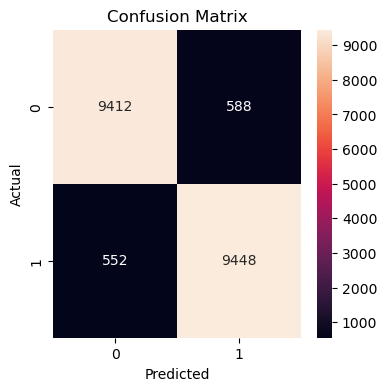

In [195]:
cm = confusion_matrix(actual,preds)
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(4,4), edgecolor='brown')
sns.heatmap(cm , annot= True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()